                                  Open         High          Low        Close  \
Date                                                                            
2014-08-20 00:00:00+01:00  6779.299805  6781.200195  6739.799805  6755.500000   
2014-08-21 00:00:00+01:00  6755.500000  6780.700195  6752.700195  6777.700195   
2014-08-22 00:00:00+01:00  6777.700195  6784.600098  6746.399902  6775.299805   
2014-08-26 00:00:00+01:00  6775.299805  6827.299805  6775.299805  6822.799805   
2014-08-27 00:00:00+01:00  6822.799805  6830.700195  6813.200195  6830.700195   

                              Volume  Dividends  Stock Splits  
Date                                                           
2014-08-20 00:00:00+01:00  466211000        0.0           0.0  
2014-08-21 00:00:00+01:00  423431000        0.0           0.0  
2014-08-22 00:00:00+01:00  571522600        0.0           0.0  
2014-08-26 00:00:00+01:00  538317700        0.0           0.0  
2014-08-27 00:00:00+01:00  481233300        0.0 

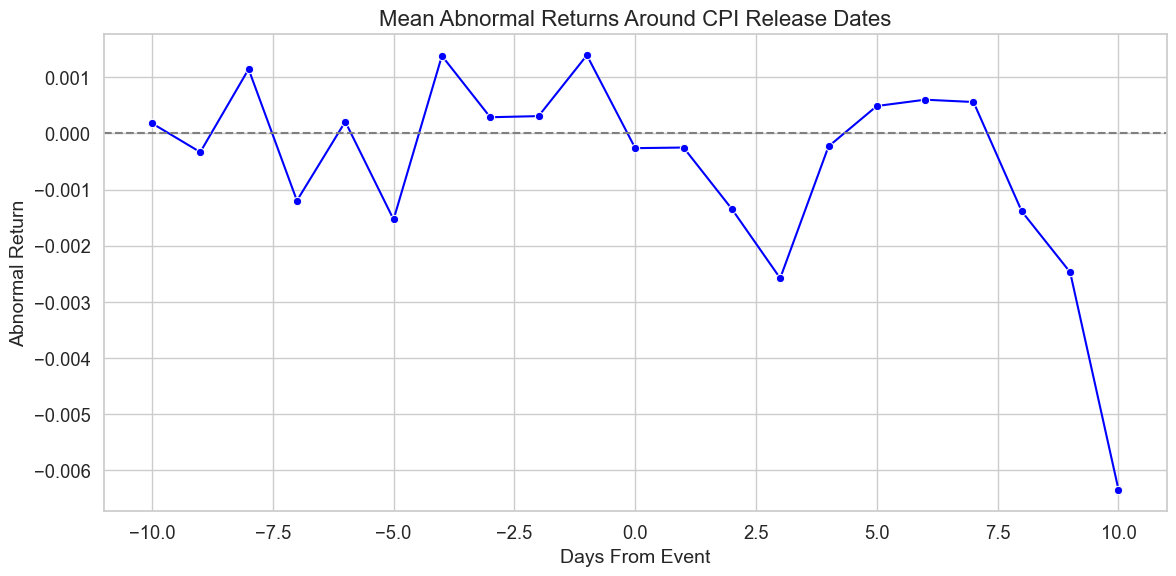

CPI Releases: T-Statistic = -0.3337, P-Value = 0.7387


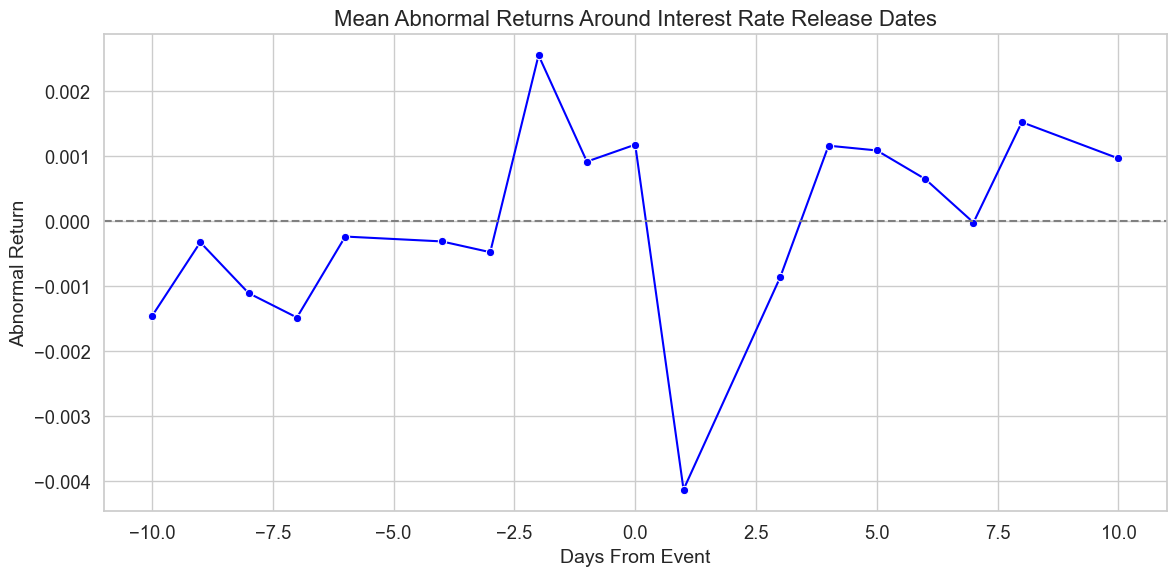

Interest Rate Releases: T-Statistic = 0.2307, P-Value = 0.8176


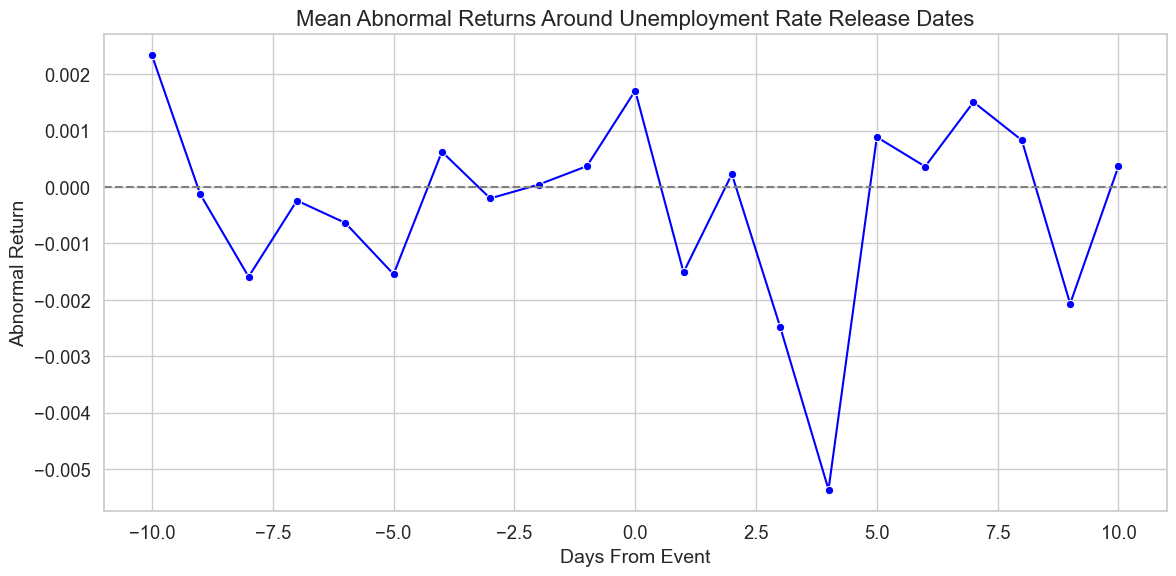

Unemployment Rate Releases: T-Statistic = -0.6806, P-Value = 0.4962


,T-Statistic,P-Value
Indicator,,
CPI,-0.3337,0.7387
Interest Rate,0.2307,0.8176
Unemployment Rate,-0.6806,0.4962


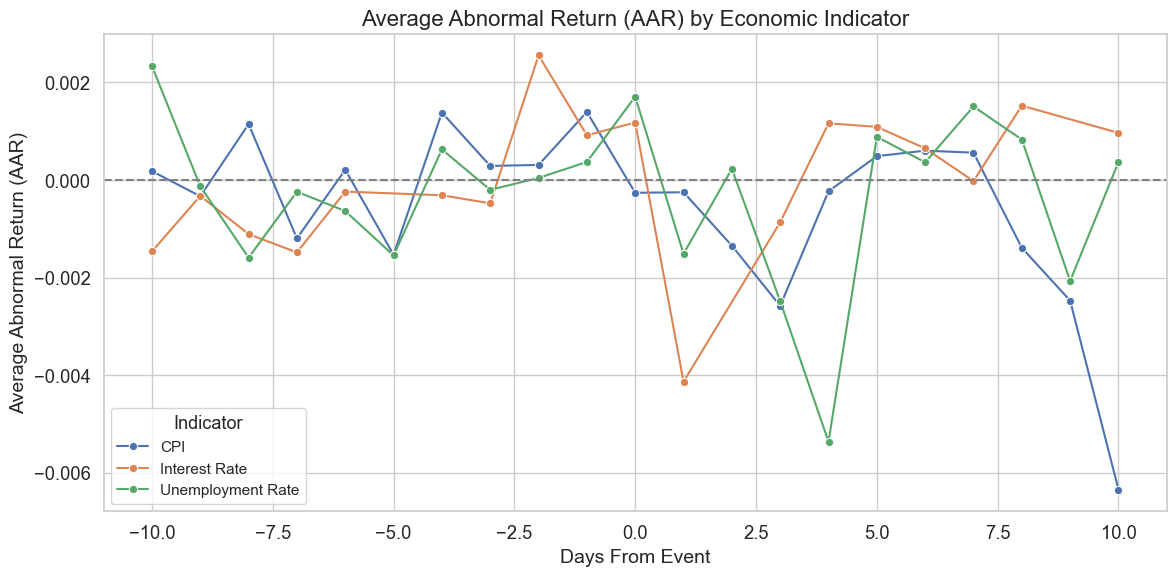

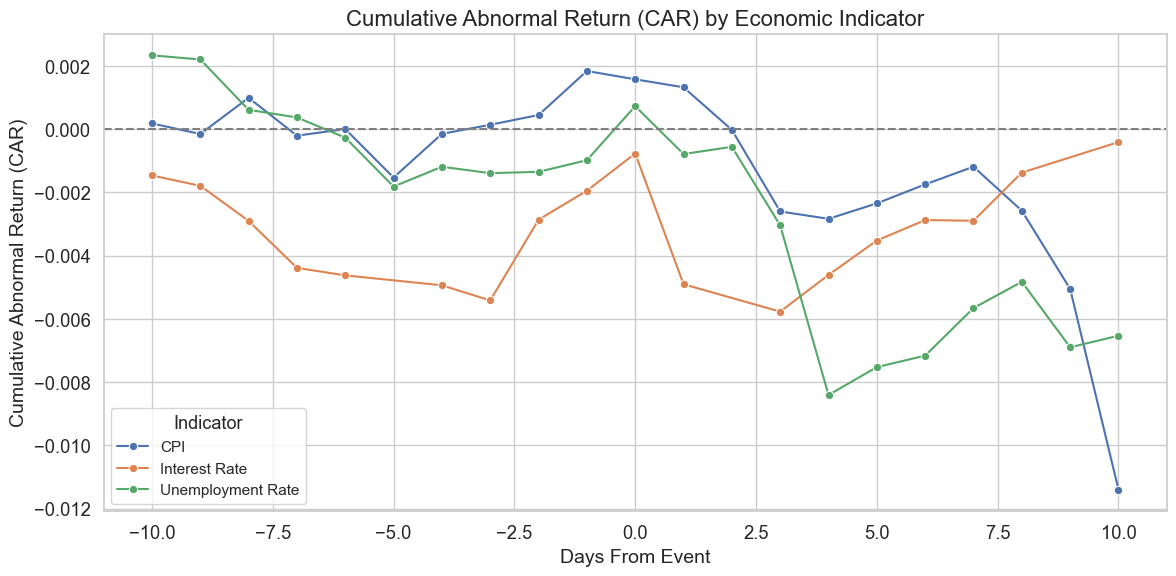

,CPI,Interest Rate,Unemployment Rate
count,21.0000,18.0000,21.0000
mean,-0.0005,-0.0000,-0.0003
std,0.0017,0.0015,0.0017
min,-0.0063,-0.0041,-0.0054
25%,-0.0013,-0.0008,-0.0015
50%,-0.0002,-0.0001,0.0000
75%,0.0005,0.0011,0.0006
max,0.0014,0.0026,0.0023


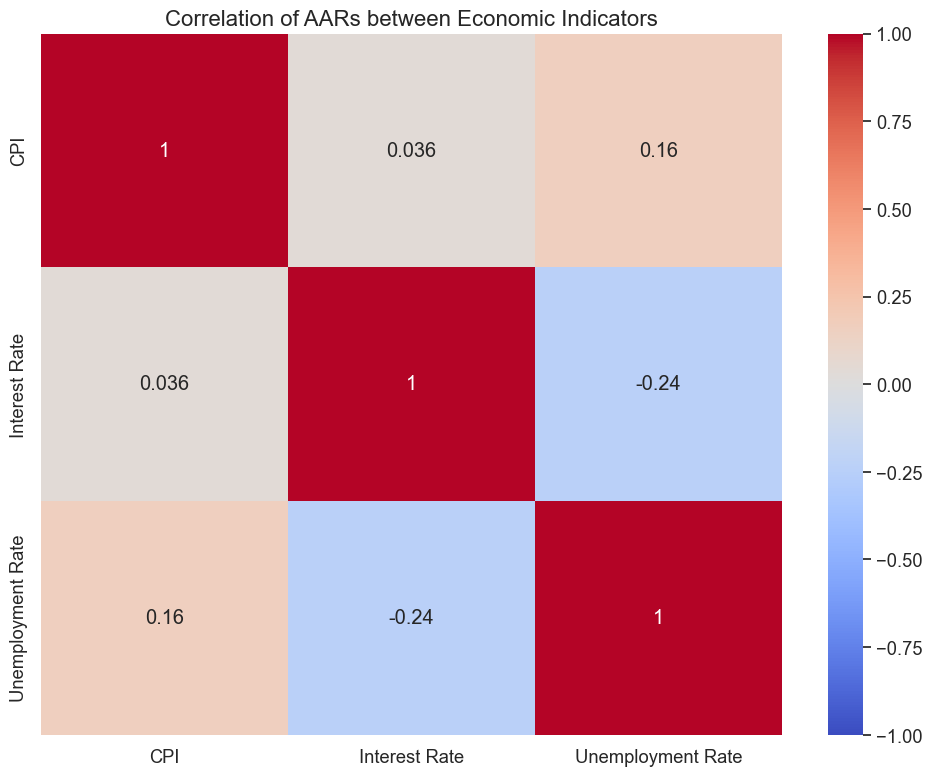

ANOVA F-statistic: 0.4735, P-value: 0.6252


,T-Statistic,P-Value,Significant
Comparison,,,
CPI vs Interest Rate,-0.9853,0.3309,0.0000
CPI vs Unemployment Rate,-0.4354,0.6656,0.0000
Interest Rate vs Unemployment Rate,0.5550,0.5822,0.0000


In [9]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
from IPython.display import display

# Set the Seaborn style for all plots
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Custom colour palette
indicator_colour_palette = sns.color_palette("deep", 3)

# Fetch FTSE 100 data for the last 10 years using the yfinance library
ftse100_ticker = yf.Ticker("^FTSE")
ftse100_historical_data = ftse100_ticker.history(period="10y")

# Display the first few rows of the fetched data
print(ftse100_historical_data.head())

# Ensure the directory exists before saving the data
output_directory = "data"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the FTSE 100 data to a CSV file
ftse100_historical_data.to_csv(os.path.join(output_directory, "ftse100_historical_data.csv"))

# Load the saved FTSE 100 data from the CSV file
ftse100_data_loaded = pd.read_csv("data/ftse100_historical_data.csv")

# Convert the 'Date' column to datetime format for further analysis
ftse100_data_loaded['Date'] = pd.to_datetime(ftse100_data_loaded['Date'], utc=True)

# Extract the 'Date' and 'Close' columns
ftse100_closing_prices = ftse100_data_loaded[['Date', 'Close']].copy()

# Format the 'Date' column to remove the timestamp
ftse100_closing_prices['Date'] = ftse100_closing_prices['Date'].dt.date

# Display the first few rows of the 'Date' and 'Close' data
print(ftse100_closing_prices.head())

# Save the Closing prices data to a CSV file
ftse100_closing_prices.to_csv('data/ftse100_closing_prices.csv', index=False)

# Load indicator release dates from a CSV file
indicator_release_dates = pd.read_csv('data/dates.csv')

indicator_release_dates['Release Date'] = pd.to_datetime(indicator_release_dates['Release Date'], utc=True)
indicator_release_dates['Release Date'] = indicator_release_dates['Release Date'].dt.date

# Split the dataset into separate DataFrames based on 'Indicator' values
interest_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Interest Rate']
cpi_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'CPI']
unemployment_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Unemployment Rate']

# Save each indicator's release indicator_release_dates to separate CSV files
interest_rate_release_dates.to_csv('data/interest_rate_release_dates.csv', index=False)
cpi_release_dates.to_csv('data/cpi_release_dates.csv', index=False)
unemployment_rate_release_dates.to_csv('data/ unemployment_rate_release_dates.csv', index=False)

# Load datasets
ftse100_data = pd.read_csv('data/ftse100_closing_prices.csv')
cpi_release_dates = pd.read_csv('data/cpi_release_dates.csv')
interest_rate_release_dates = pd.read_csv('data/interest_rate_release_dates.csv')
unemployment_rate_release_dates = pd.read_csv('data/ unemployment_rate_release_dates.csv')

# Sort the FTSE 100 data by date
ftse100_data_sorted = ftse100_data.sort_values(by='Date')

# Calculate daily returns as percentage change in 'Close' prices
ftse100_data_sorted['Return'] = ftse100_data_sorted['Close'].pct_change()

# Remove the first NaN value in 'Return' column
ftse100_data_cleaned = ftse100_data_sorted.dropna(subset=['Return'])

# Function to get event windows
def get_event_windows(market_data, event_dates, window_days):

    """
    Get the event windows around specified event dates.

    Parameters:
    market_data (pd.DataFrame): DataFrame containing the market data with a 'Date' column.
    event_dates (pd.DataFrame): DataFrame containing the event dates with a 'Release Date' column.
    window_days (int): Number of days before and after the event date to include in the window.

    Returns:
    pd.DataFrame: A DataFrame containing the market data for the specified event windows,
                  with an additional column 'Days_From_Event' indicating the number of days
                  from the event date.
    """

    # Make a copy of the market data to avoid modifying the original DataFrame
    market_data = market_data.copy()

    # Convert 'Date' columns to datetime format
    market_data['Date'] = pd.to_datetime(market_data['Date'])
    event_dates['Release Date'] = pd.to_datetime(event_dates['Release Date'])

    # Create event windows for each event date
    event_windows = pd.concat([
        market_data[(market_data['Date'] >= (event_date - pd.Timedelta(days=window_days))) & 
                    (market_data['Date'] <= (event_date + pd.Timedelta(days=window_days)))]
                   .assign(Days_From_Event=(market_data['Date'] - event_date).dt.days)
        for event_date in event_dates['Release Date']
    ], ignore_index=True)

    # The 'Days_From_Event' column represents the number of days relative to the event date
    # Negative values are days before the event, 0 is the event day, and positive values are days after the event

    return event_windows

# Function to plot returns
def plot_returns(data_frame, x_column, y_column, plot_title, x_label, y_label, marker='o', linestyle='-', line_colour='blue'):

    """
    Plot returns using Seaborn lineplot.

    Parameters:
    data_frame (pd.DataFrame): DataFrame containing the data to plot.
    x_column (str): Column name for the x-axis data.
    y_column (str): Column name for the y-axis data.
    plot_title (str): Title of the plot.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    marker (str): Marker style for the plot. Default is 'o'.
    linestyle (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'blue'.

    Returns:
    None: The function directly displays the plot.
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data_frame, x=x_column, y=y_column, marker=marker, linestyle=linestyle, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(plot_title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to plot average abnormal returns
def plot_average_abnormal_returns(event_windows, event_name, marker='o', line_style='-', line_colour='blue'):

    """
    Plot average abnormal returns around specified event dates.

    Parameters:
    event_windows (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.
    event_name (str): Name of the event to be used in the plot title.
    marker (str): Marker style for the plot. Default is 'o'.
    line_style (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'blue'.

    Returns:
    None: The function directly displays the plot.
    """

    avg_abnormal_returns = event_windows.groupby('Days_From_Event')['Abnormal Return'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_abnormal_returns, x='Days_From_Event', y='Abnormal Return', 
                 marker=marker, linestyle=line_style, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Mean Abnormal Returns Around {event_name} Release Dates', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Abnormal Return', fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to conduct event study
def event_study(ftse_data, event_dates, event_name, window_days):

    """
    Conduct an event study by analysing abnormal returns around specified event dates.

    Parameters:
    ftse_data (pd.DataFrame): DataFrame containing the FTSE data with 'Date' and 'Return' columns.
    event_dates (pd.DataFrame): DataFrame containing the event dates with a 'Release Date' column.
    event_name (str): Name of the event to be used in analysis and plotting.
    window_days (int): Number of days before and after the event date to include in the window.

    Returns:
    tuple: t-statistic, p-value, and DataFrame containing the event windows and abnormal returns.
    """

    event_windows = get_event_windows(ftse_data, event_dates, window_days)

    # Replace infinite values with NaN to prevent issues in statistical calculations
    event_windows.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Calculate the baseline mean return from non-event days
    # This serves as the simple expected return model
    baseline_mean_return = ftse_data[~ftse_data['Date'].isin(event_windows['Date'])]['Return'].mean()

    # Calculate abnormal returns by subtracting the baseline mean return from actual returns
    event_windows['Abnormal Return'] = event_windows['Return'] - baseline_mean_return

    # Perform a t-test to determine if the abnormal returns are significantly different from zero
    # The null hypothesis is that the mean abnormal return is zero
    t_statistic, p_value = stats.ttest_1samp(event_windows['Abnormal Return'].dropna(), 0)

    # Plot the average abnormal returns
    plot_average_abnormal_returns(event_windows, event_name)

    return t_statistic, p_value, event_windows

# Function to calculate AAR and CAR
def calculate_aar_car(event_window_data):

    """
    Calculate Average Abnormal Return (AAR) and Cumulative Abnormal Return (CAR).

    Parameters:
    event_window_data (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.

    Returns:
    tuple: Two pd.Series objects - AAR and CAR.
        average_abnormal_return: Average Abnormal Return for each day relative to the event.
        cumulative_abnormal_return: Cumulative Abnormal Return, which is the cumulative sum of AARs over the event window.
    """

    # Calculate Average Abnormal Return (AAR) for each day relative to the event
    average_abnormal_return = event_window_data.groupby('Days_From_Event')['Abnormal Return'].mean()

    # Calculate Cumulative Abnormal Return (CAR) by taking the cumulative sum of AAR
    # This shows the cumulative effect of the event over time
    cumulative_abnormal_return = average_abnormal_return.cumsum()

    return average_abnormal_return, cumulative_abnormal_return

# Function to plot Average Abnormal Return
def plot_aar(aar_data_dict):

    """
    Plot Average Abnormal Return (AAR) for multiple economic indicators.

    Parameters:
    aar_data_dict (dict): Dictionary containing DataFrames of AAR for each economic indicator.
                              Each DataFrame should have 'Days_From_Event' and 'AAR' columns.

    Returns:
    None: The function directly displays the plot.
    """

    plt.figure(figsize=(12, 6))
    for i, (event_name, df) in enumerate(aar_data_dict.items()):
        sns.lineplot(data=df, x='Days_From_Event', y='AAR', 
                     marker='o', label=event_name, color=indicator_colour_palette[i])
    
    plt.title('Average Abnormal Return (AAR) by Economic Indicator', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Average Abnormal Return (AAR)', fontsize=14)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend(title='Indicator', title_fontsize='13', fontsize='11')
    plt.tight_layout()
    plt.show()

# Function to plot Cumulative Abnormal Return
def plot_car(car_data_dict):

    """
    Plot Cumulative Abnormal Return (CAR) for multiple economic indicators.

    Parameters:
    car_data_dict (dict): Dictionary containing DataFrames of CAR for each economic indicator.
                              Each DataFrame should have 'Days_From_Event' and 'CAR' columns.

    Returns:
    None: The function directly displays the plot.
    """

    plt.figure(figsize=(12, 6))
    for i, (event_name, df) in enumerate(car_data_dict.items()):
        sns.lineplot(data=df, x='Days_From_Event', y='CAR', 
                     marker='o', label=event_name, color=indicator_colour_palette[i])
    
    plt.title('Cumulative Abnormal Return (CAR) by Economic Indicator', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Cumulative Abnormal Return (CAR)', fontsize=14)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend(title='Indicator', title_fontsize='13', fontsize='11')
    plt.tight_layout()
    plt.show()

# Function to create a heatmap of correlations
def plot_correlation_heatmap(aar_data):

    """
    Create and display a heatmap of correlations between AARs of different economic indicators.

    Parameters:
    aar_data (pd.DataFrame): DataFrame containing AAR data for different economic indicators.
                                 Each column (except 'Days From Event') should represent an indicator's AAR.

    Returns:
    None: The function directly displays the heatmap.
    """

    plt.figure(figsize=(10, 8))
    sns.heatmap(aar_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation of AARs between Economic Indicators', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to style a DataFrame
def style_dataframe(df):

    """
    Apply styling to a DataFrame for better visualisation.

    Parameters:
    df (pd.DataFrame): DataFrame to be styled.

    Returns:
    pd.io.formats.style.Styler: A Styler object with the applied styles.
    """

    return df.style.background_gradient(cmap='coolwarm', axis=1)\
                   .highlight_max(color='lightgreen', axis=1)\
                   .highlight_min(color='lightcoral', axis=1)\
                   .format('{:.4f}')

# Define the event window size (days before and after the event)
event_window_size = 10

# Dictionary to store results for each indicator
event_study_results = {}

# Iterate over each indicator and its corresponding event dates
for indicator_name, indicator_dates in zip(['CPI', 'Interest Rate', 'Unemployment Rate'], 
                                   [cpi_release_dates, interest_rate_release_dates, unemployment_rate_release_dates]):
    # Perform event study for each economic indicator
    t_statistic, p_value, event_windows = event_study(ftse100_data_cleaned, indicator_dates, indicator_name, event_window_size)
    event_study_results[indicator_name] = {'t_statistic': t_statistic, 'p_value': p_value, 'event_windows': event_windows}
    print(f"{indicator_name} Releases: T-Statistic = {t_statistic:.4f}, P-Value = {p_value:.4f}")

# Display the results
results_dataframe = pd.DataFrame({
    'Indicator': event_study_results.keys(),
    'T-Statistic': [res['t_statistic'] for res in event_study_results.values()],
    'P-Value': [res['p_value'] for res in event_study_results.values()]
})
styled_results = style_dataframe(results_dataframe.set_index('Indicator'))
display(styled_results)

# Calculate AAR and CAR for each indicator
aar_car_results = {event_name: calculate_aar_car(data['event_windows']) for event_name, data in event_study_results.items()}
aar_dataframes = {event_name: aar.reset_index(name='AAR') for event_name, (aar, car) in aar_car_results.items()}
car_dataframes = {event_name: car.reset_index(name='CAR') for event_name, (aar, car) in aar_car_results.items()}

# Plot AAR and CAR
plot_aar(aar_dataframes)
plot_car(car_dataframes)

# Combine AAR data for ANOVA test
combined_aar_data = pd.DataFrame({
    'Days From Event': aar_dataframes['CPI']['Days_From_Event'],
    'CPI': aar_dataframes['CPI']['AAR'],
    'Interest Rate': aar_dataframes['Interest Rate']['AAR'],
    'Unemployment Rate': aar_dataframes['Unemployment Rate']['AAR']
})


# Combine AAR data for correlation analysis and summary statistics
combined_aar_data_for_tables = pd.DataFrame({
    'CPI': aar_dataframes['CPI']['AAR'],
    'Interest Rate': aar_dataframes['Interest Rate']['AAR'],
    'Unemployment Rate': aar_dataframes['Unemployment Rate']['AAR']
})

# Display summary statistics
summary_statistics = combined_aar_data_for_tables.describe()
styled_summary = style_dataframe(summary_statistics)
display(styled_summary)

# Plot correlation heatmap
plot_correlation_heatmap(combined_aar_data_for_tables)

# Perform ANOVA test to compare the effects of different economic indicators
f_statistic, anova_p_value = stats.f_oneway(
    combined_aar_data['CPI'].dropna(),
    combined_aar_data['Interest Rate'].dropna(),
    combined_aar_data['Unemployment Rate'].dropna()
)

print(f"ANOVA F-statistic: {f_statistic:.4f}, P-value: {anova_p_value:.4f}")

# Perform pairwise t-tests with Bonferroni correction
num_comparisons = 3  # Number of pairwise comparisons
significance_level = 0.05  # Significance level
bonferroni_corrected_alpha = significance_level / num_comparisons  # Bonferroni correction

# Perform pairwise t-tests
pairwise_t_test_results = [
    ('CPI vs Interest Rate', stats.ttest_ind(combined_aar_data['CPI'].dropna(), combined_aar_data['Interest Rate'].dropna())),
    ('CPI vs Unemployment Rate', stats.ttest_ind(combined_aar_data['CPI'].dropna(), combined_aar_data['Unemployment Rate'].dropna())),
    ('Interest Rate vs Unemployment Rate', stats.ttest_ind(combined_aar_data['Interest Rate'].dropna(), combined_aar_data['Unemployment Rate'].dropna()))
]

# Display t-test results
t_test_results_df = pd.DataFrame({
    'Comparison': [res[0] for res in pairwise_t_test_results],
    'T-Statistic': [res[1].statistic for res in pairwise_t_test_results],
    'P-Value': [res[1].pvalue for res in pairwise_t_test_results],
    'Significant': [res[1].pvalue < bonferroni_corrected_alpha for res in pairwise_t_test_results] # Applying Bonferroni correction
})
styled_t_test = style_dataframe(t_test_results_df.set_index('Comparison'))
display(styled_t_test)

# The 'Significant' column indicates whether the difference between indicators is statistically significant
# after applying the Bonferroni correction to control for multiple comparisons